<a href="https://colab.research.google.com/github/Pengyu-gis/Historical-Aerial-Photos/blob/main/4_TIF_real_ESRGAN_Inference_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-ESRGAN Inference Demo

[![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/abs/2107.10833)
[![GitHub Stars](https://img.shields.io/github/stars/xinntao/Real-ESRGAN?style=social)](https://github.com/xinntao/Real-ESRGAN)
[![download](https://img.shields.io/github/downloads/xinntao/Real-ESRGAN/total.svg)](https://github.com/xinntao/Real-ESRGAN/releases)

This is a **Practical Image Restoration Demo** of our paper [''Real-ESRGAN: Training Real-World Blind Super-Resolution with Pure Synthetic Data''](https://arxiv.org/abs/2107.10833).
We extend the powerful ESRGAN to a practical restoration application (namely, Real-ESRGAN), which is trained with pure synthetic data. <br>
The following figure shows some real-life examples.

<img src="https://raw.githubusercontent.com/xinntao/Real-ESRGAN/master/assets/teaser.jpg" width="100%">

We provide a pretrained model (*RealESRGAN_x4plus.pth*) with upsampling X4.<br>
**Note that RealESRGAN may still fail in some cases as the real-world degradations are really too complex.**<br>
Moreover, it **may not** perform well on **human faces, text**, *etc*, which will be optimized later.
<br>

You can also find a **Portable Windows/Linux/MacOS executable files for Intel/AMD/Nvidia GPU.** in our [GitHub repo](https://github.com/xinntao/Real-ESRGAN). <br>
This executable file is **portable** and includes all the binaries and models required. No CUDA or PyTorch environment is needed.<br>
This executable file is based on the wonderful [Tencent/ncnn](https://github.com/Tencent/ncnn).

# 1. Preparations
Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU

in the **Runtime** menu -> **Change runtime type**

Then, we clone the repository, set up the envrironment.

In [1]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 --extra-index-url https://download.pytorch.org/whl/cu113

# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install rasterio  # For handling GeoTIFF files
!pip install -r requirements.txt
!python setup.py develop

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 712.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.14.0 requires torch>=1.13.0, but you have torch 1.11.0+cu113 which is incompatible.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 1.11.0+cu113 which is incompatible.
Cloning into 'Real-ESRGAN'...

# 2. Upload Images

Upload the images to be processed by Real-ESRGAN

In [2]:
import os
from google.colab import files
import shutil
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import Affine
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import glob

upload_folder = 'upload'
result_folder = 'results'
temp_folder = 'temp_png'

# Clean and create necessary directories
for folder in [upload_folder, result_folder, temp_folder]:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# 2. Upload GeoTIFF files
uploaded = files.upload()
for filename in uploaded.keys():
    if filename.lower().endswith('.tif') or filename.lower().endswith('.tiff'):
        dst_path = os.path.join(upload_folder, filename)
        print(f'Moving {filename} to {dst_path}')
        shutil.move(filename, dst_path)
    else:
        print(f'Skipping unsupported file format: {filename}')

Saving patch_10.tif to patch_10.tif
Moving patch_10.tif to upload/patch_10.tif


In [3]:
# 3. Extract image data and metadata, convert to PNG for processing
def tif_to_png(tif_path, png_path):
    with rasterio.open(tif_path) as src:
        # Read image data
        img_data = src.read()
        # Handle multi-band images (e.g., RGB)
        if img_data.shape[0] == 3 or img_data.shape[0] == 4:
            img = np.transpose(img_data, (1, 2, 0))
            img = np.clip(img, 0, 255).astype(np.uint8)
        else:
            # For single-band images, convert to RGB by repeating the band
            img = np.repeat(img_data, 3, axis=0)
            img = np.transpose(img, (1, 2, 0))
            img = np.clip(img, 0, 255).astype(np.uint8)
        img_pil = Image.fromarray(img)
        img_pil.save(png_path)
        # Save metadata
        meta = src.meta.copy()
    return meta

# Convert all GeoTIFFs to PNGs
for filename in os.listdir(upload_folder):
    if filename.lower().endswith('.tif') or filename.lower().endswith('.tiff'):
        tif_path = os.path.join(upload_folder, filename)
        png_filename = os.path.splitext(filename)[0] + '.png'
        png_path = os.path.join(temp_folder, png_filename)
        meta = tif_to_png(tif_path, png_path)
        print(f'Converted {filename} to {png_filename}')

Converted patch_10.tif to patch_10.png


# 3. Inference


In [4]:
# if it is out of memory, try to use the `--tile` option
# We upsample the image with the scale factor X3.5
!python inference_realesrgan.py -n RealESRGAN_x4plus -i {temp_folder} --outscale 3.5 -o {result_folder}
# Arguments
# -n, --model_name: Model names
# -i, --input: input folder or image
# --outscale: Output scale, can be arbitrary scale factore.

Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth" to /content/Real-ESRGAN/weights/RealESRGAN_x4plus.pth

100% 63.9M/63.9M [00:00<00:00, 274MB/s]
Testing 0 patch_10


# save as tif

In [7]:
# 5. Reattach georeferencing to the upscaled images
def png_to_tif(png_path, original_tif_path, upscaled_tif_path, scale_factor=3.5):
    with rasterio.open(original_tif_path) as src:
        original_meta = src.meta.copy()

    # Open the upscaled image
    img = Image.open(png_path)
    img_np = np.array(img)

    # If the image has an alpha channel, remove it
    if img_np.shape[2] == 4:
        img_np = img_np[:, :, :3]

    # Update metadata
    upscaled_meta = original_meta
    upscaled_meta.update({
        "height": img_np.shape[0],
        "width": img_np.shape[1],
        "transform": original_meta['transform'] * Affine.scale(scale_factor, scale_factor)
    })

    # Save as GeoTIFF
    with rasterio.open(upscaled_tif_path, 'w', **upscaled_meta) as dst:
        # Rasterio expects data in (bands, rows, cols)
        if img_np.ndim == 3:
            img_to_save = np.transpose(img_np, (2, 0, 1))
        else:
            img_to_save = img_np[np.newaxis, :, :]
        dst.write(img_to_save)

# 4. Process each upscaled PNG and reattach georeferencing
for png_filename in os.listdir(result_folder):
    if png_filename.lower().endswith('.png'):
        upscaled_png_path = os.path.join(result_folder, png_filename)

        # Remove the '_out' suffix to get the original base name
        base_name = os.path.splitext(png_filename)[0].replace('_out', '')
        original_tif_filename = base_name + '.tif'
        original_tif_path = os.path.join(upload_folder, original_tif_filename)

        upscaled_tif_filename = 'upscaled_' + original_tif_filename
        upscaled_tif_path = os.path.join(result_folder, upscaled_tif_filename)

        if os.path.exists(original_tif_path):
            png_to_tif(upscaled_png_path, original_tif_path, upscaled_tif_path)
            print(f'Created upscaled GeoTIFF: {upscaled_tif_filename}')
        else:
            print(f'Original GeoTIFF not found for {png_filename}, skipping georeferencing.')


Created upscaled GeoTIFF: upscaled_patch_10.tif


# 4. Visualization

In [8]:
# 6. Visualization (optional)
def display_geotiff(tif_path, upscaled_tif_path):
    with rasterio.open(tif_path) as src:
        img_input = src.read()
        img_input = np.transpose(img_input, (1, 2, 0))
        img_input = np.clip(img_input, 0, 255).astype(np.uint8)
    with rasterio.open(upscaled_tif_path) as src_up:
        img_output = src_up.read()
        img_output = np.transpose(img_output, (1, 2, 0))
        img_output = np.clip(img_output, 0, 255).astype(np.uint8)
    display(img_input, img_output)

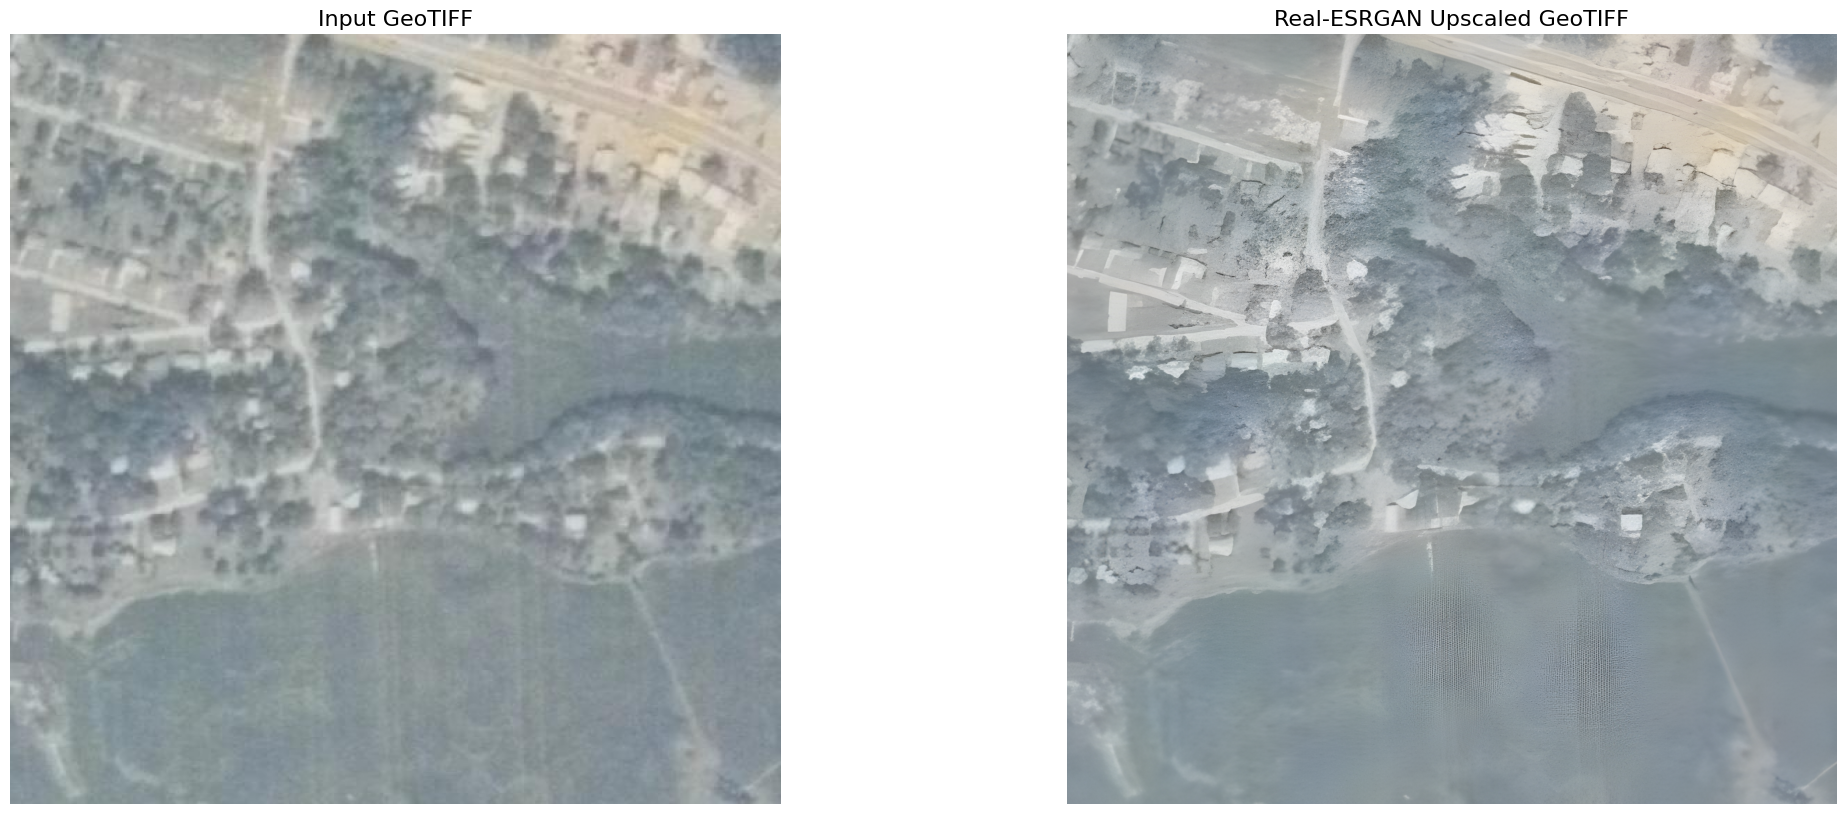

In [9]:
def display(img1, img2):
    fig = plt.figure(figsize=(25, 10))
    ax1 = fig.add_subplot(1, 2, 1)
    plt.title('Input GeoTIFF', fontsize=16)
    ax1.axis('off')
    ax2 = fig.add_subplot(1, 2, 2)
    plt.title('Real-ESRGAN Upscaled GeoTIFF', fontsize=16)
    ax2.axis('off')
    ax1.imshow(img1)
    ax2.imshow(img2)
    plt.show()

# Visualize results
for filename in os.listdir(result_folder):
    if filename.lower().startswith('upscaled_') and filename.lower().endswith('.tif'):
        upscaled_tif_path = os.path.join(result_folder, filename)
        original_tif_filename = filename.replace('upscaled_', '')
        original_tif_path = os.path.join(upload_folder, original_tif_filename)
        if os.path.exists(original_tif_path):
            display_geotiff(original_tif_path, upscaled_tif_path)